# Prof D’s Regression Sessions - Vol 3

AKA - In the (Linear) Mix(ed effects model practical for the next few
hours)

## Preamble

We’re going back in - Volume 3 of the Regression Sessions, so clearly we
are going to have to have volume 4 of the Progression Sessions. Yes,
“where is vol. 3?”, I hear you ask. I don’t know. Someone has lost it
and it’s not up on Spotify, so we’ll have to make do and jump to volume
4 - Enjoy!

## Practical Aims

1.  Experiment with running some Linear Mixed Effects Models and
    converting last week’s show-stopper multiple regression model into a
    Linear Mixed Effects version
2.  Practice moving from an initial null model to a fully-fledged model
    with fixed effects and random effects
3.  Practice interpreting your final model and seeing if you can use it
    to explain which local authority-level policy might be most
    effective at raising attainment

## Read in your data

You can use your data from last week, but I’ve created a nice clean
dataset and added a few extra spicy variables about teachers and
schools’ workforce in there for fun. All of that data is from here:
<https://explore-education-statistics.service.gov.uk/data-catalogue?themeId=b601b9ea-b1c7-4970-b354-d1f695c446f1&sortBy=newest&geographicLevel=SCH>

To save time, you might just want to download it directly from here:
https://github.com/adamdennett/QM/blob/main/sessions/L6_data/Performancetables_130242/2022-2023/school_data_2223.csv

### 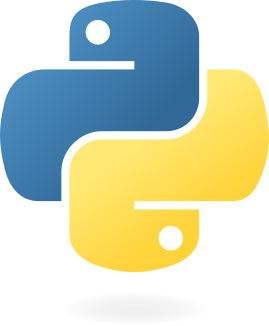

In [ ]:

import pandas as pd
import numpy as np
import janitor
from pathlib import Path
import statsmodels.api as sm

# little function to define the file root on different machines
def find_qm_root(start_path: Path = Path.cwd(), anchor: str = "QM") -> Path:
    """
    Traverse up from the start_path until the anchor folder (e.g. 'QM' or 'QM_Fork')      is found. Returns the path to the anchor folder.
    """
    for parent in [start_path] + list(start_path.parents):
        if parent.name == anchor:
            return parent
    raise FileNotFoundError(f"Anchor folder '{anchor}' not found in path      hierarchy.")
  
qm_root = find_qm_root()
base_path = qm_root / "sessions" / "L6_data" / "Performancetables_130242" / "2022-2023"
na_all = ["", "NA", "SUPP", "NP", "NE", "SP", "SN", "LOWCOV", "NEW", "SUPPMAT", "NaN"]

qm_root = find_qm_root()
base_path = qm_root / "sessions" / "L6_data" / "Performancetables_130242" / "2022-2023"
na_all = ["", "NA", "SUPP", "NP", "NE", "SP", "SN", "LOWCOV", "NEW", "SUPPMAT", "NaN"]

england_filtered = pd.read_csv(base_path / "school_data_2223.csv", na_values=na_all, dtype={"URN": str})

# Log-transform safely: replace non-positive values with NaN
england_filtered['log_ATT8SCR'] = np.where(england_filtered['ATT8SCR'] > 0, np.log(england_filtered['ATT8SCR']), np.nan)
england_filtered['log_PTFSM6CLA1A'] = np.where(england_filtered['PTFSM6CLA1A'] > 0, np.log(england_filtered['PTFSM6CLA1A']), np.nan)

# Drop rows with NaNs in either column
england_filtered_clean = england_filtered.dropna(subset=['log_ATT8SCR', 'log_PTFSM6CLA1A'])

## The Warm-up - Last week’s Multiple Regression Show Stopper

-   To get us going we are going to run our ‘show-stopper’ model from
    last week so that we can compare this with a final linear mixed
    effects version at the end of the practical.
-   You should run your best model (without any interaction effects)
    from last week, however, to help you along my best model from last
    week looked like this:

### 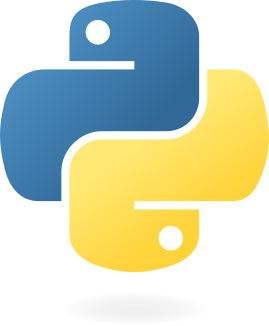

In [ ]:
import numpy as np
import statsmodels.formula.api as smf

# Filter rows where all log-transformed variables are > 0
england_filtered_clean = england_filtered_clean[
    (england_filtered_clean['PTFSM6CLA1A'] > 0) &
    (england_filtered_clean['PERCTOT'] > 0) &
    (england_filtered_clean['PNUMEAL'] > 0)
].copy()

# Create log-transformed columns
england_filtered_clean['log_ATT8SCR'] = np.log(england_filtered_clean['ATT8SCR'])
england_filtered_clean['log_PTFSM6CLA1A'] = np.log(england_filtered_clean['PTFSM6CLA1A'])
england_filtered_clean['log_PERCTOT'] = np.log(england_filtered_clean['PERCTOT'])
england_filtered_clean['log_PNUMEAL'] = np.log(england_filtered_clean['PNUMEAL'])

# Fit the model
model = smf.ols(
    formula='log_ATT8SCR ~ log_PTFSM6CLA1A + log_PERCTOT + log_PNUMEAL + OFSTEDRATING + gor_name + PTPRIORLO + ADMPOL_PT',
    data=england_filtered_clean
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_ATT8SCR   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     868.5
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:05:18   Log-Likelihood:                 3411.9
No. Observations:                2902   AIC:                            -6786.
Df Residuals:                    2883   BIC:                            -6672.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


## Building Our Linear Mixed Effects Model

### Stage 1 - The Null / Variance Components Model for Ofsted Ratings

-   If you remember from the lecture, in order to determine whether
    running a linear mixed effects / multilevel model is necessary, if
    you have categorical / grouping factors in your data set (**random
    effects**), you should run the null model to see how much variance
    the groups in your data are explaining.
-   In our data, we had a couple of different grouping variable
    candidates:
    -   Ofsted Rating (how ‘good’ or otherwise a school is as determined
        by the Office for Standards in Education - Ofsted)
    -   Geographical groups. In our data these are Regions and the Local
        Authorities within those regions.
-   Below is some code to visualise those groups as boxplots.

### 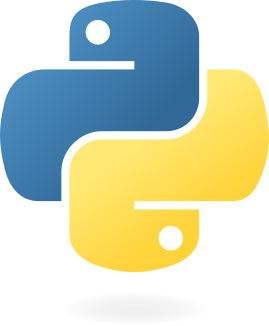

([0, 1, 2, 3, 4], [Text(0, 0, 'Special Measures'), Text(1, 0, 'Serious Weaknesses'), Text(2, 0, 'Requires improvement'), Text(3, 0, 'Good'), Text(4, 0, 'Outstanding')])

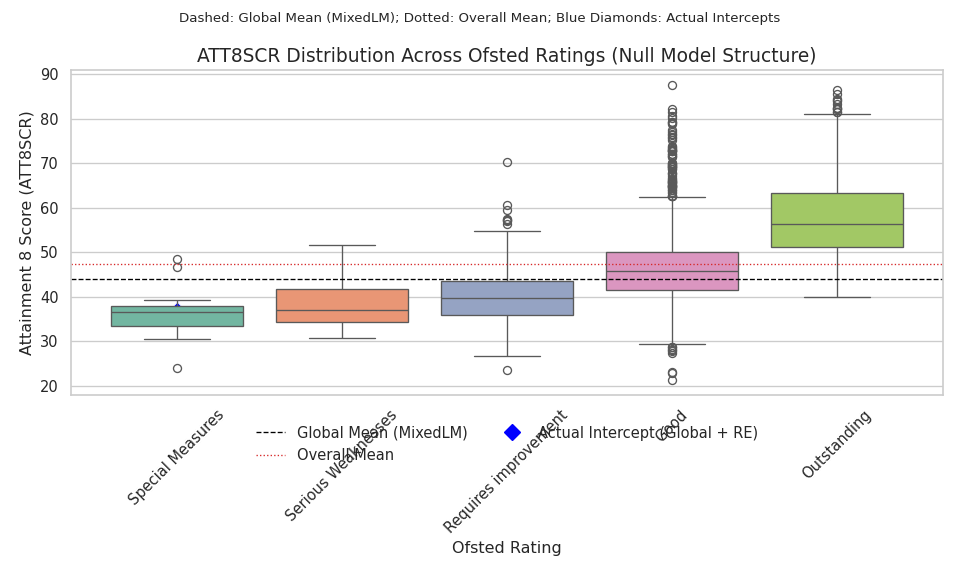

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sns.set_theme(style="whitegrid")

# --- Ensure OFSTEDRATING is clean and categorical ---
rating_order = ["Special Measures", "Serious Weaknesses", "Requires improvement", "Good", "Outstanding"]
england_filtered_clean["OFSTEDRATING"] = england_filtered_clean["OFSTEDRATING"].astype(str)
england_filtered_clean["OFSTEDRATING"] = pd.Categorical(
    england_filtered_clean["OFSTEDRATING"],
    categories=rating_order,
    ordered=True
)

# --- Keep valid rows (ATT8SCR present and rating in our order) ---
df = england_filtered_clean.dropna(subset=["ATT8SCR"]).copy()
df = df[df["OFSTEDRATING"].isin(rating_order)]

# --- Fit MixedLM null model (random intercept by OFSTEDRATING) ---
mixed_model = sm.MixedLM.from_formula("ATT8SCR ~ 1", groups="OFSTEDRATING", data=df)
mixed_fit = mixed_model.fit(method="lbfgs")

# --- Global mean (fixed intercept) ---
global_mean = mixed_fit.params["Intercept"] if "Intercept" in mixed_fit.params.index else float(mixed_fit.params.iloc[0])

# --- Robust random-effects extraction ---
def get_re_value(effect):
    # effect may be a pandas Series (with/without 'Intercept'), ndarray, or list
    if isinstance(effect, pd.Series):
        return float(effect["Intercept"]) if "Intercept" in effect.index else float(effect.iloc[0])
    arr = np.asarray(effect).ravel()
    return float(arr[0]) if arr.size > 0 else np.nan

random_effects = mixed_fit.random_effects  # dict: {group_label: effect_vector}
group_effects = {str(k): get_re_value(v) for k, v in random_effects.items()}

ranef_df = pd.DataFrame({
    "OFSTEDRATING": list(group_effects.keys()),
    "ranef": list(group_effects.values())
}).sort_values("OFSTEDRATING")

# --- Actual intercepts = global mean + random effect ---
ranef_df["actual_intercept"] = global_mean + ranef_df["ranef"]

# --- Overall mean from raw data ---
overall_mean = df["ATT8SCR"].mean()

# --- Plot: boxplots + lines + actual intercept markers ---
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x="OFSTEDRATING", y="ATT8SCR", palette="Set2", ax=ax)

# Reference lines
ax.axhline(global_mean, color="black", linestyle="--", linewidth=1)
ax.axhline(overall_mean, color="#d62728", linestyle=":", linewidth=1)

# Overlay actual intercepts (blue diamonds) per rating
sns.scatterplot(
    data=ranef_df,
    x="OFSTEDRATING", y="actual_intercept",
    marker="D", s=100, color="blue",
    ax=ax
)

# Titles & labels
ax.set_title("ATT8SCR Distribution Across Ofsted Ratings (Null Model Structure)", fontsize=14)
fig.suptitle("Dashed: Global Mean (MixedLM); Dotted: Overall Mean; Blue Diamonds: Actual Intercepts", fontsize=10)
ax.set_xlabel("Ofsted Rating")
ax.set_ylabel("Attainment 8 Score (ATT8SCR)")
plt.xticks(rotation=45)

### The Interclass Correlation Coefficient - ICC

-   Again, if you recall from the lecture, the ICC is simply the ratio
    between the between the between group variance and the total
    variance
-   The higher the ICC (closer to 1), the more variance is due to
    differences between groups (i.e. differences between the Ofsted
    rating of schools) than within groups (i.e. between schools within
    Ofsted rating bands)
-   This can be judged visually with a stacked density plot:
    -   High ICC = distinct, non-overlapping humps
    -   Low ICC = density plots all overlapping on-top of each other
-   **Remember** A high ICC is a strong indication that a multilevel /
    mixed effects model is a suitable modelling strategy to pursue to
    try and explain these group-level differences

### 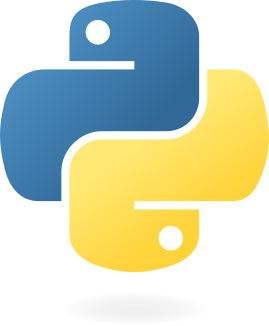

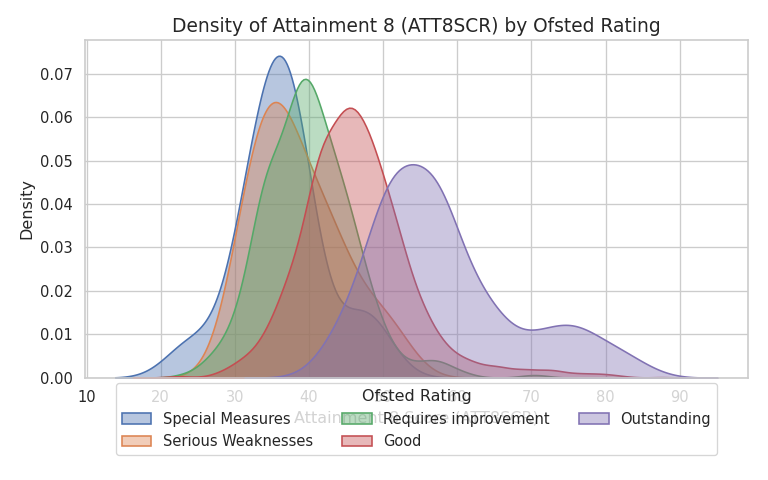

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

rating_order = ["Special Measures", "Serious Weaknesses", "Requires improvement", "Good", "Outstanding"]
england_filtered_clean["OFSTEDRATING"] = pd.Categorical(
    england_filtered_clean["OFSTEDRATING"],
    categories=rating_order,
    ordered=True
)

plot_df = england_filtered_clean.dropna(subset=["ATT8SCR", "OFSTEDRATING"]).copy()

# Create figure and axis manually
fig, ax = plt.subplots(figsize=(8, 5))

# Plot KDE for each category
for rating in rating_order:
    subset = plot_df[plot_df["OFSTEDRATING"] == rating]
    sns.kdeplot(
        data=subset,
        x="ATT8SCR",
        fill=True,
        alpha=0.4,
        linewidth=1.2,
        ax=ax,
        label=rating
    )

# Titles & labels
ax.set_title("Density of Attainment 8 (ATT8SCR) by Ofsted Rating", fontsize=14)
ax.set_xlabel("Attainment 8 Score (ATT8SCR)")
ax.set_ylabel("Density")
ax.legend(title="Ofsted Rating", loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=3)

plt.tight_layout()
plt.show()

## Running the Null Model and Calculating the Inter-Class Correlation Coefficient (ICC)

-   You will also remember from the lecture, that we can run our null
    model using standard statistical software. - In R, we use the `lmer`
    package, whereas in Python for now we’ll use `statsmodels`

-   First run the model as below:

### 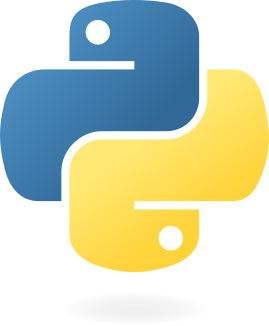

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Ensure OFSTEDRATING is categorical
rating_order = ["Special Measures", "Serious Weaknesses", "Requires improvement", "Good", "Outstanding"]
england_filtered_clean["OFSTEDRATING"] = pd.Categorical(
    england_filtered_clean["OFSTEDRATING"],
    categories=rating_order,
    ordered=True
)

# Drop missing values for P8MEA and OFSTEDRATING
df = england_filtered_clean.dropna(subset=["ATT8SCR", "OFSTEDRATING"]).copy()

# Fit null model: random intercept for OFSTEDRATING
null_model = sm.MixedLM.from_formula("ATT8SCR ~ 1", groups="OFSTEDRATING", data=df)
null_fit = null_model.fit()

# Summary
print(null_fit.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: ATT8SCR    
No. Observations:   2902    Method:             REML       
No. Groups:         5       Scale:              60.9126    
Min. group size:    16      Log-Likelihood:     -10091.1281
Max. group size:    2076    Converged:          Yes        
Mean group size:    580.4                                  
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        43.982    3.976 11.063 0.000 36.190 51.775
OFSTEDRATING Var 77.648    7.129                           

-   Once we have run the model we can calculate the ICC:

### 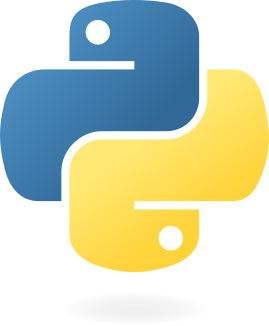

In [ ]:
var_components = null_fit.cov_re.iloc[0, 0]  # random intercept variance
resid_var = null_fit.scale                   # residual variance
icc = var_components / (var_components + resid_var)
print(f"ICC: {icc:.3f}")

ICC: 0.560

## Null Model Visualisation

-   You will know by know that I am a big advovate of visualising
    everything as we go, so here is a visualisation of the null model
    which shows the different intercept values for the different group
-   Remember, we can think of the intercept as the ‘baseline’ expected
    for our dependent variable

### 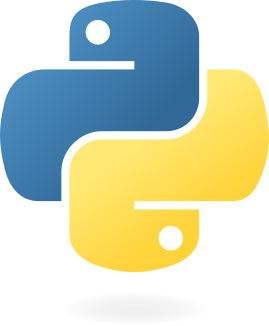

([0, 1, 2, 3, 4], [Text(0, 0, 'Good'), Text(1, 0, 'Outstanding'), Text(2, 0, 'Requires improvement'), Text(3, 0, 'Serious Weaknesses'), Text(4, 0, 'Special Measures')])

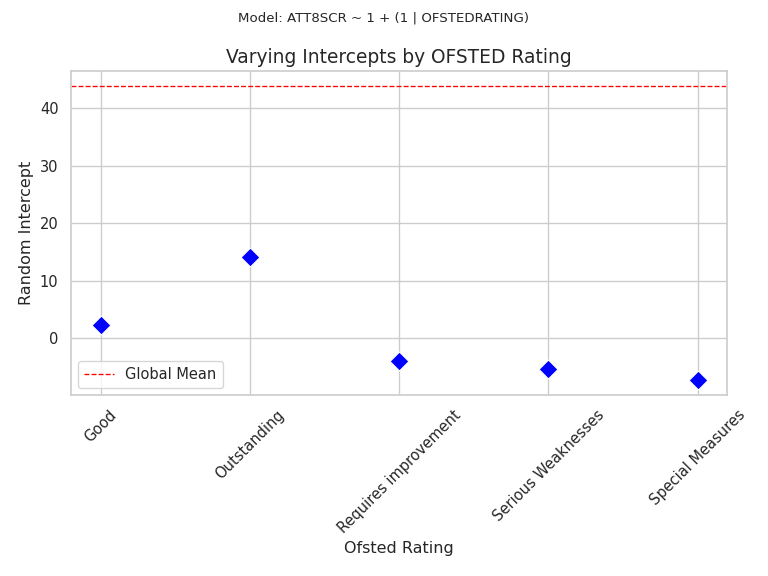

In [ ]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure OFSTEDRATING is categorical
rating_order = ["Special Measures", "Serious Weaknesses", "Requires improvement", "Good", "Outstanding"]
england_filtered_clean["OFSTEDRATING"] = pd.Categorical(
    england_filtered_clean["OFSTEDRATING"],
    categories=rating_order,
    ordered=True
)

# Drop missing values
df = england_filtered_clean.dropna(subset=["ATT8SCR", "OFSTEDRATING"]).copy()

# Fit null model: random intercept for OFSTEDRATING
null_model = sm.MixedLM.from_formula("ATT8SCR ~ 1", groups="OFSTEDRATING", data=df)
null_fit = null_model.fit()

# Extract global mean (fixed effect intercept)
global_mean = null_fit.params["Intercept"]

# Extract random effects for each group (take first value from each Series)
random_effects = null_fit.random_effects
ranef_df = pd.DataFrame({
    "OFSTEDRATING": list(random_effects.keys()),
    "Intercept": [float(effect.iloc[0]) for effect in random_effects.values()]
})

# Plot random intercepts
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ranef_df, x="OFSTEDRATING", y="Intercept", s=100, color="blue", marker="D")

# Add dashed line for global mean
plt.axhline(global_mean, color="red", linestyle="--", linewidth=1, label="Global Mean")

# Titles and labels
plt.title("Varying Intercepts by OFSTED Rating", fontsize=14)
plt.suptitle("Model: ATT8SCR ~ 1 + (1 | OFSTEDRATING)", fontsize=10)
plt.xlabel("Ofsted Rating")
plt.ylabel("Random Intercept")
plt.xticks(rotation=45)

## Stage 2 - Adding an initial Fixed Effect

### Model with a Fixed Effect Predictor (random intercepts, fixed slopes)

-   In the lecture you saw that after running the null model (assuming
    the ICC indicates that a mixed effects model is recommended) the
    next stage is to test that model by adding in a predictor variable
-   You can use any predictor you like and once you get used to running
    these models, you can even skip this step, but for now we are going
    to build gradually and I am going to experiment with the %
    disadvantaged variable

### 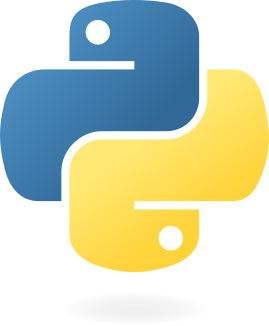

Original shape: (2961, 118)

After dropna: (2902, 118)

Groups: ['Good' 'Outstanding' 'Requires improvement' 'Serious Weaknesses'
 'Special Measures']

Fixed effects: Intercept          4.478310
log_PTFSM6CLA1A   -0.206907
dtype: float64

Group adjustments:            OFSTEDRATING      blup
0                  Good -0.006606
1           Outstanding  0.130557
2  Requires improvement -0.109573
3    Serious Weaknesses -0.119260
4      Special Measures -0.185965

<Axes: xlabel='PTFSM6CLA1A', ylabel='ATT8SCR'>

<Axes: xlabel='PTFSM6CLA1A', ylabel='ATT8SCR'>

<Axes: xlabel='PTFSM6CLA1A', ylabel='ATT8SCR'>

Text(0.5, 1.0, 'ATT8SCR vs Disadvantaged (%): Log-transformed model predictions')

Text(0.5, 0, 'PTFSM6CLA1A')

Text(0, 0.5, 'ATT8SCR')

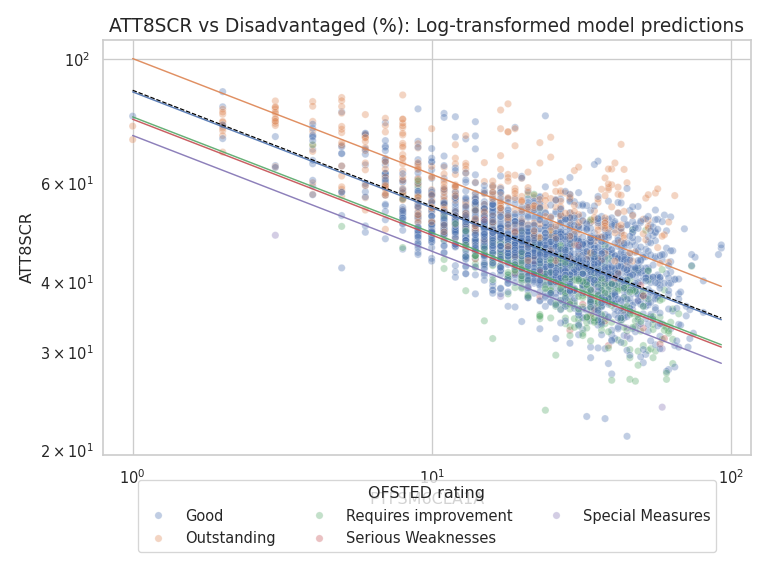

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# 1. Clean data and check
df = england_filtered_clean.copy()
print("Original shape:", df.shape)

### Random Intercepts and Random Slopes Model

-   And again, in the lecture we saw that the next stage once you have
    allowed your intercepts to vary, is to allow your slopes to vary as
    well
-   Here’s the visualisation of those varying slopes and intercepts:

### 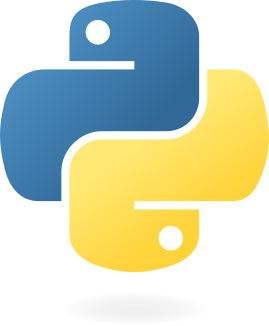

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)

<Axes: xlabel='PTFSM6CLA1A', ylabel='ATT8SCR'>

<Axes: xlabel='PTFSM6CLA1A', ylabel='ATT8SCR'>

<Axes: xlabel='PTFSM6CLA1A', ylabel='ATT8SCR'>

Text(0.5, 1.0, 'ATT8SCR vs Disadvantaged (%): Log-transformed mixed-effects model')

Text(0.5, 0, '% Disadvantaged (PTFSM6CLA1A)')

Text(0, 0.5, 'Attainment 8 Score (ATT8SCR)')

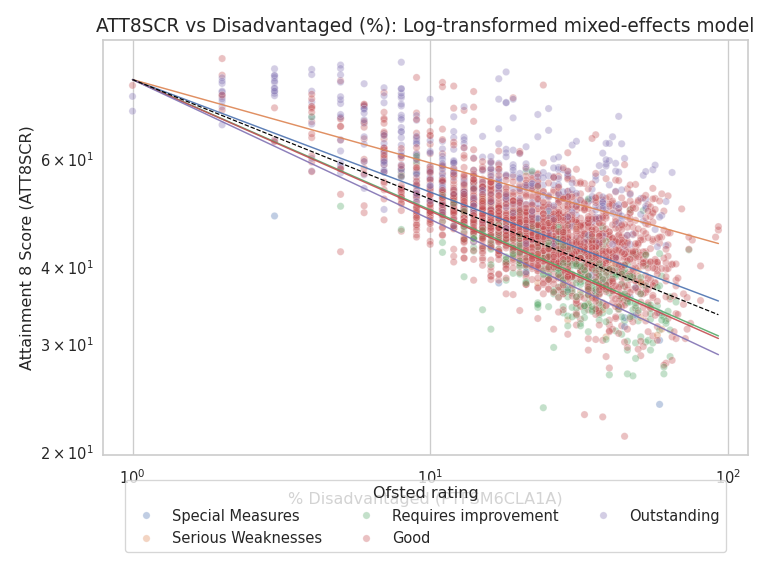

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = england_filtered_clean.copy()
df["log_ATT8SCR"] = np.log(df["ATT8SCR"])
df["log_PTFSM6CLA1A"] = np.log(df["PTFSM6CLA1A"])

# Drop rows with missing values in any relevant column
df = df.dropna(subset=["log_ATT8SCR", "log_PTFSM6CLA1A", "OFSTEDRATING"])

# Fit mixed model with random intercepts and slopes
model = smf.mixedlm(
    "log_ATT8SCR ~ log_PTFSM6CLA1A",
    df,
    groups=df["OFSTEDRATING"],
    re_formula="~log_PTFSM6CLA1A"
)
lme_rs = model.fit(reml=False, method="lbfgs")

### Fitting a Basic Random Effect and Random Slope Model

-   And now we can also fit the model using statistical software

### 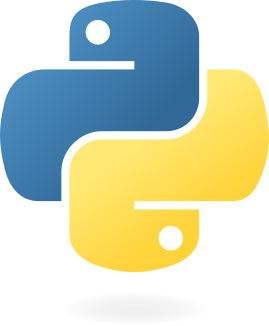

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

df_clean = df.dropna(subset=["log_ATT8SCR", "log_PTFSM6CLA1A", "OFSTEDRATING"])

# Example
model = smf.mixedlm(
    "log_ATT8SCR ~ log_PTFSM6CLA1A",
    data=df_clean,
    groups=df_clean["OFSTEDRATING"],
    re_formula="~log_PTFSM6CLA1A"
)

result = model.fit()

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/statsmodels/base/model.py:607: Conve

                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     log_ATT8SCR
No. Observations:       2902        Method:                 REML       
No. Groups:             5           Scale:                  0.0141     
Min. group size:        16          Log-Likelihood:         2047.0001  
Max. group size:        2076        Converged:              No         
Mean group size:        580.4                                          
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    4.400    0.037 117.605 0.000  4.327  4.473
log_PTFSM6CLA1A             -0.196    0.017 -11.789 0.000 -0.229 -0.164
Group Var                    0.002                                     
Group x log_PTFSM6CLA1A Cov -0.001                                     
log_PTFSM

### Interpretation

**NB - this applies to these models above, you will have different
interpretations depending on the variables you have chosen**

Here we have fitted a basic random intercept and random slope model
using comparable methods in R and Python.

#### Fixed Effects

Intercept (≈ 4.39) This is the expected value of log(ATT8SCR) when
log(PTFSM6CLA1A) is zero (i.e., when the predictor is at its baseline).
In practical terms, it’s the average log score for schools at the
reference level of the predictor.

Slope for log(PTFSM6CLA1A) (≈ −0.195) For each 1-unit increase in the
log of PTFSM6CLA1A, the log of ATT8SCR decreases by about 0.195. Since
both variables are logged, this is roughly an elasticity: higher
PTFSM6CLA1A is associated with lower ATT8SCR.

#### Random Effects

OFSTEDRATING intercept variance (≈ 0.00021) There’s very little
variation in baseline performance across OFSTED categories after
accounting for the fixed effect.

Random slope variance (≈ 0.00138) The effect of log(PTFSM6CLA1A) barely
varies by OFSTED category—almost zero. The correlation between intercept
and slope is estimated as 1.00, which is why you see the “singular fit”
warning (R) and Convergence Warnings in Python: the model is on the
boundary, meaning the random slope is not really supported by the data.

Residual variance (≈ 0.014) This is the within-group variability not
explained by the model.

## Experimenting with your own linear mixed effects models

At this point, this is about all you need to know, for now, to run your
own linear mixed effects model.

In general you might find it’s a bit easier to run these models in R
using the `lme4` package, however, there are Python Packages that allow
you to run linear mixed effects models using R-like syntax like
`Pymer4`.

Please experiment - I was running into problems with `Pymer4` in this
practical, so you might need to persevere a bit if you want to persist
on the Python track.

`Pymer4` - <https://eshinjolly.com/pymer4/>

`lme4` - <https://github.com/lme4/lme4/>

I didn’t touch on the Bayesian versions of these models either (a world
that would have taken us many more weeks to get into!). But you can run
Bayesian Linear Mixed Effects models too and there are packages in both
R and Python to do this.

In Python you have `bambi` - <https://bambinos.github.io/bambi/>

In R you have `RStan` - <https://mc-stan.org/rstan/index.html>

If you remember from the lecture, there are a range of variations on the
basic model which may or may not be appropriate in different situations.
I’ll reproduce the table below:

| Element | Meaning | Sample Equation |
|-------------------|------------------------------|------------------------|
| `(1|g)` | Null Model or Varying Intercept Model | `P8 ~ 1 + (1 | OFSTEDRATING)` |
| `(1|g1/g2)` | Multilevel Model with intercept varying within g1 and for g2 within g1 | `P8 ~ 1 + (1 | LocalAuthority/Region)` |
| `(1|g1) + (1|g2)` | Intercept varying among g1 and g2 | `P8 ~ 1 + (1 | OFSTEDRATING) + (1 | Region)` |
| `(0+x|g)` | Varying Slope Model | `P8 ~ Disadvantage + (0 + Disadvantage | OFSTEDRATING)` |
| `x + (x|g)` | Varying and correlated intercepts and slopes | `P8 ~ Disadvantage + (Disadvantage | OFSTEDRATING)` |
| `x + (x||g)` | Uncorrelated Intercepts and Slopes | `P8 ~ Disadvantage + (Disadvantage || OFSTEDRATING)` |

-   You might want to experiment with only one or two of these linear
    mixed effects models. Below you will see I have incorporated both
    multilevel (local authorities nested within regions) and varying
    intercepts. There are almost infinite combinations.

### Final Task

-   You should try and extend your final multiple regression showstopper
    model to incorporate one or more logical random effect. What can you
    say about the random effects in your model?
-   I have played around with a few additional variables too, you don’t
    have to do this, but you can if you wish.

#### My final mixed effects model

### 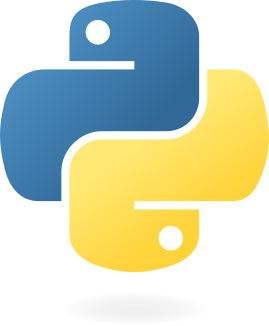

In [ ]:
#Sorry, I really tried to get this working properly with pymer, but I couldn't - too much pain. 

# Try the R version instead, or, if you manage to get as far as getting pymer4 to work, you can translate my model below into pymer4 syntax (as it uses R under the hood)

#### Fitted Values vs Observed Attainment 8 (how good is the model?)

-   Here I have overlaid the Brighton Schools again - anything above the
    line (a positive residual) shows the school is doing better than
    expected, given the variables we have used to predict attainment.
    Anything below, the school is performing worse than expected.

(`geom_point()`).

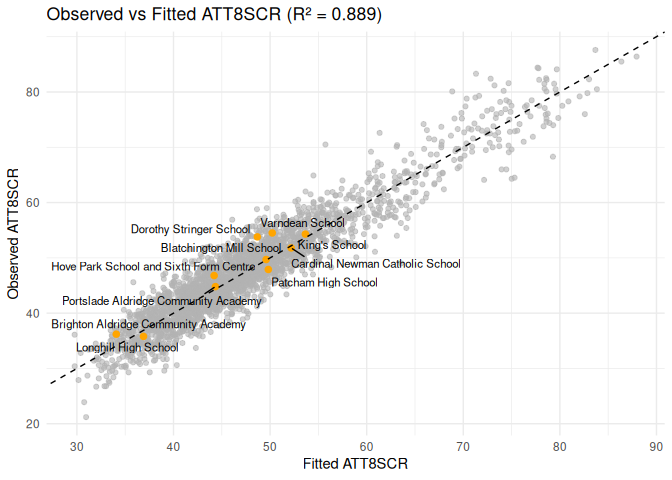

In [ ]:
# Add fitted values (back-transform to original scale)
england_filtered_clean <- england_filtered_clean %>%
  mutate(fitted_ATT8SCR = exp(fitted(lme11)))

# Compute R²
r2 <- cor(england_filtered_clean$ATT8SCR, england_filtered_clean$fitted_ATT8SCR, use = "complete.obs")^2

# Identify Brighton schools
brighton_schools <- england_filtered_clean %>%
  filter(LANAME == "Brighton and Hove")

# Plot
ggplot(england_filtered_clean, aes(x = fitted_ATT8SCR, y = ATT8SCR)) +
  geom_point(color = "grey70", alpha = 0.6) +
  geom_point(data = brighton_schools, color = "orange", size = 2) +
  geom_text_repel(data = brighton_schools,
                  aes(label = SCHNAME.x),
                  color = "black",
                  size = 3,
                  max.overlaps = 20) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(
    title = paste0("Observed vs Fitted ATT8SCR (R² = ", round(r2, 3), ")"),
    x = "Fitted ATT8SCR",
    y = "Observed ATT8SCR"
  ) +
  theme_minimal()

-   We can also run some diagnostic plots to double check our model
    adheres to the various assumptions required

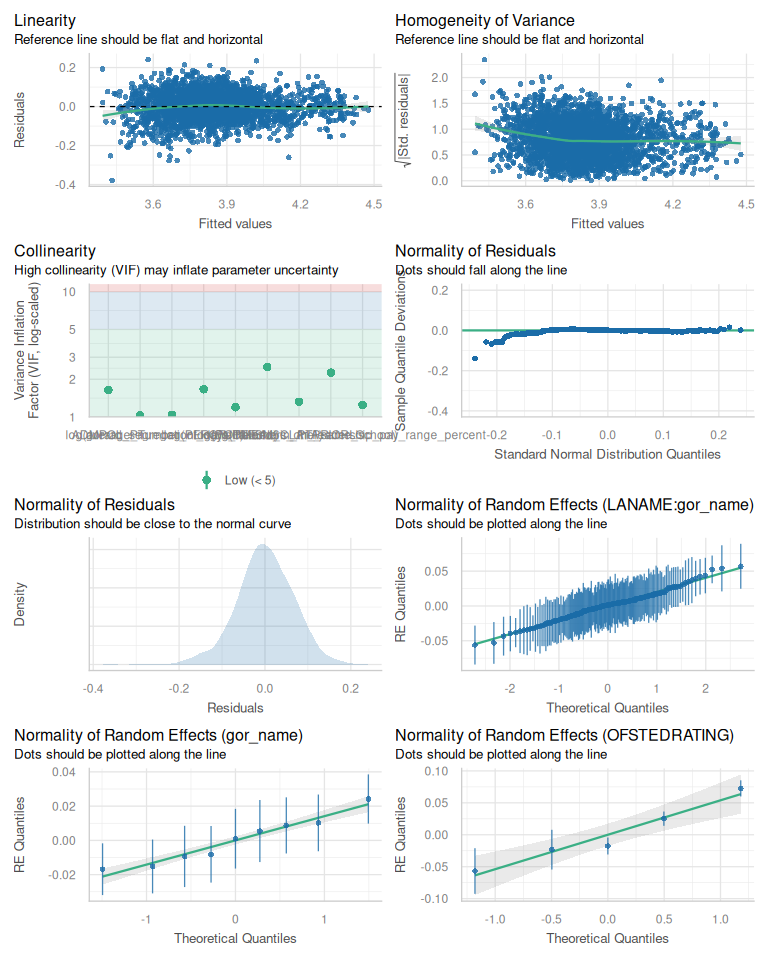

In [ ]:
library(performance)
check_model(lme11)

### Interpreting your outputs

#### Random Effects

Turning the **Std.Dev** to an **approximate percentage difference**:
$\%= 100 \times (exp(SD) - 1)$. This gives a feel for how much
Attainment 8 changes for a **+1 SD higher** group intercept.

##### lme11 (Overall Attainment 8)

-   **OFSTEDRATING**: Var = 0.0026, **SD = 0.051** → ~**+5.2%** per +1
    SD

-   **Region (gor_name)**: Var = 0.00024, **SD = 0.015** → ~**+1.5%**

-   **LA within Region**: Var = 0.00066, **SD = 0.026** → ~**+2.6%**

-   **Residual (school-level/unexplained)**: Var = 0.00471, **SD =
    0.069** → ~**+7.1%**

Taking the sum of all the variances and dividing each individual
variance by this total gives the proportion of variance explained by
each random effect:

-   **OFSTEDRATING**: **31.8%**

-   **Region**: **2.9%**

-   **LA within Region**: **8.1%**

-   **Residual**: **57.3%**

-   **Total variance**: 0.00822

While Ofsted Rating helps explain a lot of the variance - some 32%, most
of the variability is between individual schools within each group.

#### Fixed Effects

From **lme11 (overall attainment)**:

-   **Most influential negative factors**:

    -   **Overall absence (log(PERCTOT))**: t ≈ -28.6 → Higher absence
        strongly reduces attainment.

    -   **Prior low attainment (PTPRIORLO)**: t ≈ -28.5 → Schools with
        more students entering low-performing do worse.

    -   **Proportion disadvantaged (log(PTFSM6CLA1A))**: t ≈ -17.1 →
        Higher concentration of disadvantaged pupils lowers overall
        attainment, but is much less important than the first two
        factors.

-   **Positive factors**:

    -   **Selective admissions (ADMPOL_PTSEL)**: t ≈ 9.0 → Selective
        schools boost attainment.

    -   **Proportion EAL (log(PNUMEAL))**: t ≈ 7.5 → Linguistic
        diversity slightly improves outcomes.

    -   **Teacher Stability (log(remained_in_the_same_school))**: t ≈
        6.4 → Teachers remaining in the same school helps.

-   **Moderate negatives**:

    -   **Teacher Absence days**: t ≈ -5.6.

    -   **Proportion of Teachers on Leadership pay %**: t ≈ -3.0.

-   **Not significant**: Other admission policy, segregation index.

#### Overall Fit

Comparing the Observed and Fitted Values and calculating an $R^2$ value
from that, we can explain almost 90% of the variation in Attainment 8.
Schools in Brighton are mainly showing positive residuals - in other
words, performing much better than other similar schools in England with
similar profiles.

#### Benefits of LME over OLS

-   **Accounts for clustering** (schools within OFSTED/regions).

-   **Shrinkage / “Partial pooling”** reduces overfitting and improves
    predictions.

-   **Decomposes variance** across levels so we can see how, for
    example, having a better Ofsted score might compare with lowering
    absence.

-   **School-specific predictions** are more useful.

### Policy Interpretations and Using AI to help with the specific, contextual translation of outputs

-   Below I have pulled out some of the schools in Brighton.
-   One of the nice things about AI is it is very good at quickly
    turning specific situations into policy-relevant examples using the
    models we have just built. Have a look at the table below and I will
    give you an example of a question that produces some very
    interesting results:

In [ ]:
# Packages
library(dplyr)
library(tidyr)
library(stringr)
library(lme4)
library(tibble)

# --- Schools of interest ---
target_urns  <- c("114581", "14608", "136164", "114580")
target_names <- c("Longhill High School", "Patcham High School", "Brighton Aldridge Community Academy", "Dorothy Stringer School")

# --- Variables of interest (from your final model) ---
vars_of_interest <- c(
  "PERCTOT",        # % overall absence
  "PTFSM6CLA1A",    # % disadvantaged
  "PNUMEAL",        # cohort size proxy
  "PTPRIORLO",      # prior low attainment
  "ADMPOL_PT",      # admissions policy
  "gorard_segregation", # LA-level segregation
  "remained_in_the_same_school",   # total teachers remained_in_the_same_school
  "teachers_on_leadership_pay_range_percent", # leadership pay %
  "average_number_of_days_taken.x"  # average sick days
)

# 1) Subset to target schools
schools_sub <- england_filtered_clean %>%
  filter(URN %in% target_urns | SCHNAME.x %in% target_names) %>%
  select(URN, SCHNAME.x, OFSTEDRATING, gor_name, LANAME, all_of(vars_of_interest)) %>%
  distinct()

# 2) Extract random effects from lme11
re_list <- lme4::ranef(lme11)

# 2a) OFSTEDRATING random intercepts
re_ofsted <- re_list$OFSTEDRATING %>%
  as.data.frame() %>%
  rownames_to_column("OFSTEDRATING") %>%
  rename(re_OFSTEDRATING = `(Intercept)`)

# 2b) gor_name random intercepts
re_gor <- re_list$gor_name %>%
  as.data.frame() %>%
  rownames_to_column("gor_name") %>%
  rename(re_gor_name = `(Intercept)`)

# 2c) Nested random intercepts for LANAME:gor_name
grp_names <- names(re_list)
lan_gor_grp <- grp_names[grepl("LANAME.*gor_name|gor_name.*LANAME", grp_names)][1]

if (grepl("^LANAME", lan_gor_grp)) {
  re_lan_gor <- re_list[[lan_gor_grp]] %>%
    as.data.frame() %>%
    rownames_to_column("key") %>%
    separate(key, into = c("LANAME", "gor_name"), sep = ":", remove = TRUE) %>%
    rename(re_LANAME_gor = `(Intercept)`)
} else {
  re_lan_gor <- re_list[[lan_gor_grp]] %>%
    as.data.frame() %>%
    rownames_to_column("key") %>%
    separate(key, into = c("gor_name", "LANAME"), sep = ":", remove = TRUE) %>%
    rename(re_LANAME_gor = `(Intercept)`) %>%
    relocate(LANAME, gor_name)
}

# 3) Join random effects and compute total RE
schools_with_re <- schools_sub %>%
  left_join(re_ofsted, by = "OFSTEDRATING") %>%
  left_join(re_gor, by = "gor_name") %>%
  left_join(re_lan_gor, by = c("LANAME", "gor_name")) %>%
  mutate(RE_total = re_OFSTEDRATING + re_gor_name + re_LANAME_gor)

# 4) Predictions (log scale -> back-transform)
pred_log_fixed <- predict(lme11, newdata = schools_with_re, re.form = NA)
pred_log_cond  <- predict(lme11, newdata = schools_with_re, re.form = NULL)

# Bias correction
sigma2 <- sigma(lme11)^2
bias_factor <- exp(0.5 * sigma2)

schools_with_re <- schools_with_re %>%
  mutate(
    pred_fixed   = exp(pred_log_fixed),
    pred_cond    = exp(pred_log_cond),
    pred_cond_bc = pred_cond * bias_factor
  )

# 5) Display table
row_order <- c(
  "PERCTOT", "PTFSM6CLA1A", "PNUMEAL", "PTPRIORLO", "ADMPOL_PT",
  "gorard_segregation", "remained_in_the_same_school", "teachers_on_leadership_pay_range_percent", "average_number_of_days_taken.x",
  "RE: OFSTEDRATING", "RE: gor_name", "RE: LANAME:gor_name", "RE: total",
  "Baseline ATT8 (fixed only)", "Baseline ATT8 (incl. RE)", "Baseline ATT8 (incl. RE, bias-corrected)"
)

display_tbl <- schools_with_re %>%
  transmute(
    SCHNAME.x,
    PERCTOT = formatC(PERCTOT, format = "f", digits = 1),
    PTFSM6CLA1A = formatC(PTFSM6CLA1A, format = "f", digits = 1),
    PNUMEAL = formatC(PNUMEAL, format = "f", digits = 1),
    PTPRIORLO = formatC(PTPRIORLO, format = "f", digits = 1),
    ADMPOL_PT = as.character(ADMPOL_PT),
    gorard_segregation = formatC(gorard_segregation, format = "f", digits = 3),
    remained_in_the_same_school = formatC(remained_in_the_same_school, format = "f", digits = 3),
    teachers_on_leadership_pay_range_percent = formatC(teachers_on_leadership_pay_range_percent, format = "f", digits = 1),
    average_number_of_days_taken.x = formatC(average_number_of_days_taken.x, format = "f", digits = 3),
    `RE: OFSTEDRATING` = formatC(re_OFSTEDRATING, format = "f", digits = 3),
    `RE: gor_name` = formatC(re_gor_name, format = "f", digits = 3),
    `RE: LANAME:gor_name` = formatC(re_LANAME_gor, format = "f", digits = 3),
    `RE: total` = formatC(RE_total, format = "f", digits = 3),
    `Baseline ATT8 (fixed only)` = formatC(pred_fixed, format = "f", digits = 1),
    `Baseline ATT8 (incl. RE)` = formatC(pred_cond, format = "f", digits = 1),
    `Baseline ATT8 (incl. RE, bias-corrected)` = formatC(pred_cond_bc, format = "f", digits = 1)
  ) %>%
  pivot_longer(cols = -SCHNAME.x, names_to = "Variable", values_to = "Value") %>%
  pivot_wider(names_from = SCHNAME.x, values_from = Value) %>%
  mutate(Variable = factor(Variable, levels = row_order)) %>%
  arrange(Variable)


knitr::kable(
  display_tbl %>% arrange(Variable),
  align = "l"
)

> **Question for my AI**
>
> Given the outputs from the model above and the specific detail the
> variables for each school. Considering Longhill and Patcham schools,
> can you show what percentage point change would be required for each
> variable to affect an increase of 5 more Attainment 8 points?

| Variable | Change (unit) | Longhill Current | Longhill Required Δ | Patcham Current | Patcham Required Δ |
|------------|------------|------------|------------|------------|------------|
| **PERCTOT** (overall absence) *(log)* | pp | 13.4 | **−5.9 pp** | 9.2 | **−3.3 pp** |
| **PTFSM6CLA1A** (% disadvantaged) *(log)* | pp | 29.0 | −24.3 pp | 19.0 | −14.2 pp |

This output is highly illustrative and shows that given the different
starting points for each school, not only are different levels of effort
required to reach the same outcomes (Patcham would need to reduce
absence by fewer percentage points to achieve the same 5 point
attainment 8 increase), but we can see how much more effective reducing
absence is than reducing levels of disadvantage - with Longhill needing
to reduce its levels of disadvantaged students down from 29% to to 5% to
achieve the same point score improvement.

Given the policy levers that Brighton and Hove Council tried to pull,
this is very important information.

### Task

See if you can experiment with feeding your own tame AI (Copilot/Chat
GPT, ClaudeAI, Gemini etc. will all do this slightly differently and
with greater or lesser success) with your model outputs and some
specifics about some schools or local authorities, and then ask some
questions of it to aid in some insightful interpretation.

> **Caution**
>
> I shouldn’t need to tell you to proceed with caution when asking an AI
> to interpret your outputs. It will get things wrong so don’t just copy
> and paste! Interrogate, ask follow-up questions. Ask for
> reinterpretations or to explain specific features.

## Extension Activities

I think you’ve probably had enough at this point, but you will hopefully
find many uses for these models in your future work.